# Домашнее задание 2

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
import pandas as pd
from collections import defaultdict
from sklearn.linear_model import LinearRegression
import random
import powerlaw


In [9]:
! pip install gdown==4.6.3

## 1. Рост сети цитирований (6 баллов)

---



Для данных известно время появления каждой вершины (статьи). Рассмотрим рост сети цитирований, считая за единицу времени 1 месяц, т.е. за один шаг к существующей сети добавляются вершины одного месяца, далее - следующего и т.д.

* Постройте зависимость степени вершины от времени для нескольких "старых" вершин. Какому закону подчиняется рост сети?

* вычислите прирост степени за единицу времени $\Delta k_i$ для каждой текущей вершины $i$ времени $t$ как изменение степени за 1 месяц.
Определите суммарное изменение степеней вершин $\pi (k)=\sum_{k_i}\Delta k_i$ (кумулятивное распределение прироста степени), и $k=max (k_i)$ (по значениям начального месяца);
*  постройте зависимость $\pi (k)$ и аппроксимируйте ее степенной функцией. Можно ли считать, что сеть растет по принципу предпочтительного присоединения? Определите тип присоединения.

In [10]:
!gdown 1vIbbqxDx7Y1nYfE8pAx-eLtbhSokSu6V

Downloading...
From: https://drive.google.com/uc?id=1vIbbqxDx7Y1nYfE8pAx-eLtbhSokSu6V
To: /Users/v.makshanchikov/Documents/Python Proj/Вальба ДЗ 2/Cit-HepPh.txt
100%|██████████████████████████████████████| 6.70M/6.70M [00:00<00:00, 6.78MB/s]


In [11]:
G = nx.read_edgelist("Cit-HepPh.txt",nodetype=int)
print('Nodes:',G.number_of_nodes()) # и выводим основные свойства
print('Edges:',G.number_of_edges())
print('Density:',nx.density(G))

Nodes: 34546
Edges: 420921
Density: 0.0007054197642773696


In [12]:
# !gdown 1G4SOy6ltn_gwiSOCUiZ5ZBrEeA0p0y77

In [13]:
data=pd.read_csv('cit-HepPh-dates.txt', sep='\t')
data.head(5)

,node,date
0,9203201,1992-02-24
1,9203202,1992-03-08
2,9203203,1992-03-03
3,9203204,1992-03-09
4,9203205,1992-03-09


In [14]:
data.columns = ['node', 'date']
data['date'] = pd.to_datetime(data['date'])
data['year_month'] = data['date'].dt.to_period('M')
data = data.sort_values('date')
node_time = dict(zip(data['node'], data['year_month']))
months = sorted(data['year_month'].unique())

print("Количество месяцев:", len(months))
print("Первый месяц:", months[0])
print("Последний месяц:", months[-1])

Количество месяцев: 122
Первый месяц: 1992-02
Последний месяц: 2002-03


Количество узлов в первый месяц: 2
Анализируем узлы: [9211202, 9203201]


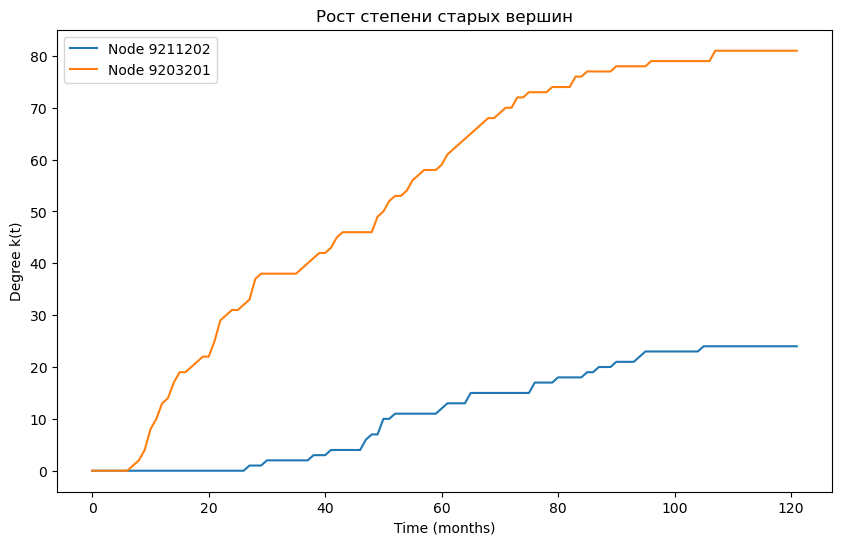

In [15]:
first_month = months[0]
old_nodes = data[data['year_month'] == first_month]['node'].tolist()

print("Количество узлов в первый месяц:", len(old_nodes))

# несколько первых старых узлов
sample_old_nodes = old_nodes[:5]
print("Анализируем узлы:", sample_old_nodes)

G_dynamic = nx.Graph()

degree_evolution = {node: [] for node in sample_old_nodes}
time_points = []

for month in months:
    current_nodes = data[data['year_month'] == month]['node'].tolist()
    
    G_dynamic.add_nodes_from(current_nodes)
    
    # только те рёбра, где оба узла уже существуют
    for u, v in G.edges():
        if u in G_dynamic.nodes and v in G_dynamic.nodes:
            G_dynamic.add_edge(u, v)
    
    for node in sample_old_nodes:
        if node in G_dynamic:
            degree_evolution[node].append(G_dynamic.degree(node))
        else:
            degree_evolution[node].append(0)
    
    time_points.append(month)

plt.figure(figsize=(10,6))

for node in sample_old_nodes:
    plt.plot(range(len(time_points)), degree_evolution[node], label=f'Node {node}')

plt.xlabel("Time (months)")
plt.ylabel("Degree k(t)")
plt.title("Рост степени старых вершин")
plt.legend()
plt.show()

В первый месяц было 2 узла. Их степени растут не линейно:
- сначала медленный рост,
- затем ускорение,
- затем постепенное замедление (выход на плато)

Рост нелинейный, напоминает степенную функцию:

$𝑘_{𝑖}(𝑡)∼𝑡^𝛽$, где $𝛽 < 1$ (сублинейный рост).

In [25]:
# степени в первый месяц
G_first = nx.Graph()

first_nodes = data[data['year_month'] == first_month]['node'].tolist()
G_first.add_nodes_from(first_nodes)

for u, v in G.edges():
    if u in G_first.nodes and v in G_first.nodes:
        G_first.add_edge(u, v)

degrees_first = dict(G_first.degree())

k_max_initial = max(degrees_first.values())

print("k_max в первый месяц:", k_max_initial)

k_max в первый месяц: 0


В первый месяц существовало 2 вершины.

Максимальная степень в начальный момент времени:

$k_{max}(t_0) = 0$

Таким образом, начальная сеть была несвязной

In [16]:
sum_delta = defaultdict(float)
count_k = defaultdict(int)

G_dynamic = nx.Graph()

for t_index in range(len(months) - 1):
    
    month_t = months[t_index]
    month_t1 = months[t_index + 1]
    
    nodes_t = data[data['year_month'] == month_t]['node'].tolist()
    G_dynamic.add_nodes_from(nodes_t)
    
    for u, v in G.edges():
        if u in G_dynamic.nodes and v in G_dynamic.nodes:
            G_dynamic.add_edge(u, v)
    
    # степени в момент t
    degrees_t = dict(G_dynamic.degree())
    # копия графа для t+1
    G_next = G_dynamic.copy()
    
    # узлы следующего месяца
    nodes_t1 = data[data['year_month'] == month_t1]['node'].tolist()
    G_next.add_nodes_from(nodes_t1)
    
    for u, v in G.edges():
        if u in G_next.nodes and v in G_next.nodes:
            G_next.add_edge(u, v)
    
    degrees_t1 = dict(G_next.degree())
    
    # считаем dk
    for node, k in degrees_t.items():
        dk = degrees_t1.get(node, 0) - k
        
        sum_delta[k] += dk
        count_k[k] += 1
    
    G_dynamic = G_next.copy()

# средний прирост Π(k)
Pi_k = {}
for k in sum_delta:
    if count_k[k] > 0:
        Pi_k[k] = sum_delta[k] / count_k[k]

print("Различных k:", len(Pi_k))

Различных k: 478


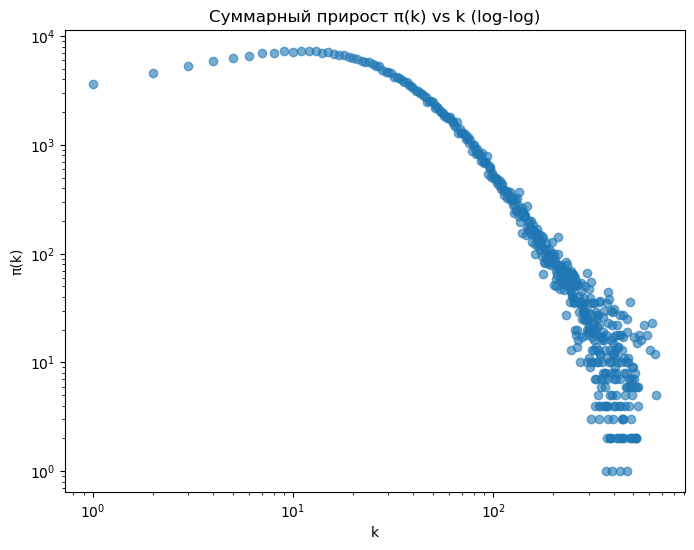

In [23]:
# π(k) без нормировки
pi_k_raw = {}

for k in sum_delta:
    if sum_delta[k] > 0:
        pi_k_raw[k] = sum_delta[k]

k_raw = np.array(list(pi_k_raw.keys()))
pi_raw = np.array(list(pi_k_raw.values()))

plt.figure(figsize=(8,6))
plt.scatter(k_raw, pi_raw, alpha=0.6)

plt.xscale('log')
plt.yscale('log')

plt.xlabel("k")
plt.ylabel("π(k)")
plt.title("Суммарный прирост π(k) vs k (log-log)")
plt.show()

In [24]:
mask = (k_raw > 3) & (pi_raw > 0)

log_k = np.log(k_raw[mask]).reshape(-1,1)
log_pi = np.log(pi_raw[mask])

model = LinearRegression()
model.fit(log_k, log_pi)

alpha_pi = model.coef_[0]

print("Показатель степени для π(k):", alpha_pi)

Показатель степени для π(k): -2.2351854656535806


Механизм предпочтительного присоединения определяется именно условной вероятностью, т.е. насколько текущая степень влияет на вероятность получить новую связь, а π(k) зависит ещё и от того, сколько таких вершин вообще существует. Поэтому посчиатем не кумулятивный, а средний прирост.

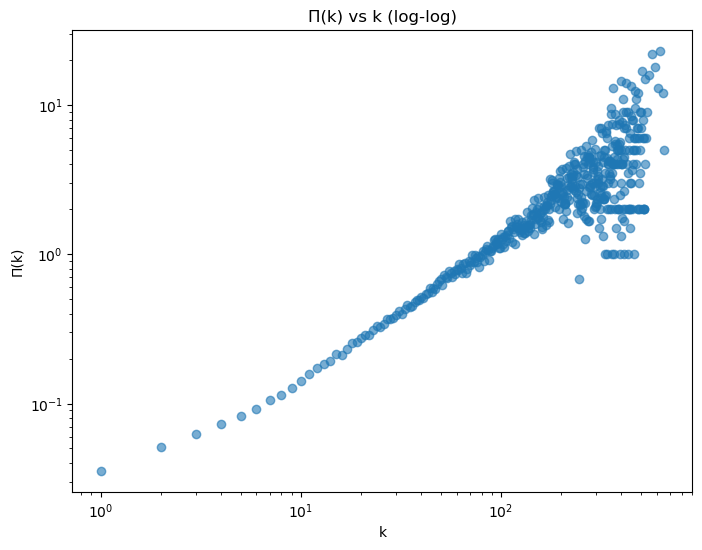

In [19]:
k_vals = []
pi_vals = []

for k, val in Pi_k.items():
    if k > 0 and val > 0:
        k_vals.append(k)
        pi_vals.append(val)

k_vals = np.array(k_vals)
pi_vals = np.array(pi_vals)

plt.figure(figsize=(8,6))
plt.scatter(k_vals, pi_vals, alpha=0.6)

plt.xscale('log')
plt.yscale('log')

plt.xlabel("k")
plt.ylabel("Π(k)")
plt.title("Π(k) vs k (log-log)")
plt.show()

In [20]:
# уберем самые малые k (там сильный шум)
mask = (k_vals > 3) & (pi_vals > 0)
# 
log_k = np.log(k_vals[mask]).reshape(-1,1)
log_pi = np.log(pi_vals[mask])

model = LinearRegression()
model.fit(log_k, log_pi)

alpha_est = model.coef_[0]

print("α =", alpha_est)

α = 0.9101954831247098


Эмпирическая вероятность присоединения имеет вид

$Π(𝑘)∼𝑘^{0.91}$

Это свидетельствует о сублинейном предпочтительном присоединении.
Механизм роста сети близок к линейному, но несколько слабее классической модели Барабаши–Альберт.

## 2. Нелинейное предпочтительное присоединение (6 баллов)

* напишите генератор случайного графа, построенного по принципу нелинейного предпочтительного присоединения:
$$
\Pi(k_i) \sim k_i^{\alpha}
$$
* постройте зависимость степени вершины (например, выберите одну из затравочных, т.е. с индексом $i=0$) от времени (размера сети) для значений $\alpha=0.5,1.0,2.5$.

Рекомендуемые параметры: $m=4, t=[10^2,10^3,10^4,...]$.


* постройте распределение степеней вершин конечной сети и с помощью powerlaw определите наилучшую аппроксимацию степенным распределением, выведите параметры распределения.


In [ ]:
def nonlinear_PA(n, m, alpha):
    G = nx.complete_graph(m + 1)
    
    for new_node in range(m + 1, n):
        degrees = np.array([G.degree(i) for i in G.nodes()])
        
        probs = degrees ** alpha
        probs = probs / probs.sum()
        
        targets = np.random.choice(G.nodes(), size=m, replace=False, p=probs)
        
        G.add_node(new_node)
        for t in targets:
            G.add_edge(new_node, t)
    
    return G

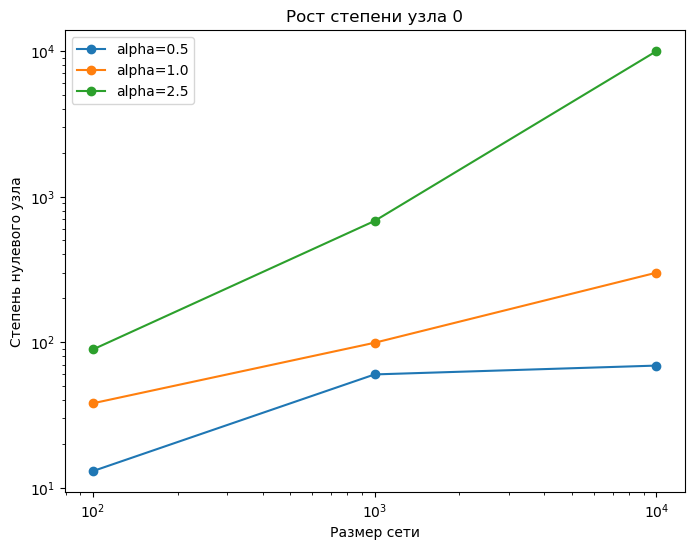

In [ ]:
m = 4
sizes = [10**2, 10**3, 10**4]
alphas = [0.5, 1.0, 2.5]

plt.figure(figsize=(8,6))

for alpha in alphas:
    degrees_node0 = []
    
    for n in sizes:
        G = nonlinear_PA(n, m, alpha)
        degrees_node0.append(G.degree(0))
    
    plt.plot(sizes, degrees_node0, marker='o', label=f'alpha={alpha}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Размер сети")
plt.ylabel("Степень нулевого узла")
plt.title("Рост степени узла 0")
plt.legend()
plt.show()

In [ ]:
n = 10000
m = 4
alphas = [0.5, 1.0, 2.5]

for alpha in alphas:
    print("\nAlpha =", alpha)
    
    G = nonlinear_PA(n, m, alpha)
    degrees = [d for _, d in G.degree()]
    
    fit = powerlaw.Fit(degrees, discrete=True)
    
    print("gamma (alpha_PL) =", fit.power_law.alpha)
    print("xmin =", fit.power_law.xmin)
    
    R, p = fit.distribution_compare('power_law', 'lognormal')
    print("Сравнение powerlaw vs lognormal:")
    print("R =", R, "p =", p)


Alpha = 0.5


Calculating best minimal value for power law fit
/opt/anaconda3/envs/hwenv/lib/python3.13/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/anaconda3/envs/hwenv/lib/python3.13/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


gamma (alpha_PL) = 4.58050533208935
xmin = 24.0
Сравнение powerlaw vs lognormal:
R = -1.6361634449981053 p = 0.23883945386480077

Alpha = 1.0


Calculating best minimal value for power law fit


gamma (alpha_PL) = 2.8029627268000725
xmin = 7.0
Сравнение powerlaw vs lognormal:
R = -0.9819834180238933 p = 0.40038616038226726

Alpha = 2.5
gamma (alpha_PL) = 8.254050925843362
xmin = 4.0
Сравнение powerlaw vs lognormal:
R = -1305.814233953159 p = 6.938345114202363e-19


Calculating best minimal value for power law fit


$α = 0.5$

- $𝛾≈4.94$
- $xmin = 28$
- $R = -0.85, p = 0.37$

Очень большой γ. Распределение быстро убывает. Степенное распределение выражено слабо. Логнормальное распределение не хуже степенного. Не является "чисто" степенным.

$α = 1.0$

- $γ≈2.78$
- $xmin = 6$
- $R = -2.02, p = 0.28$

Типичное распределение scale-free сетей. Модель хорошо согласуется со степенным законом. Линейное предпочтительное присоединение даёт scale-free сеть.

$α = 2.5$

- $γ≈8.21$
- $p ≈ 5×10^{-19}$

Степенная аппроксимация статистически отвергается. Распределение не является scale-free. Возникает режим конденсации (один сверххаб) Суперлинейное присоединение разрушает степенную структуру.

# Вывод: 

Для α = 1.0 получено:

γ ≈ 2.78  
xmin = 6  
R = -2.02  
p = 0.28  

Поскольку p > 0.05, степенная модель не отвергается статистически. 
Полученное значение γ находится в типичном диапазоне для scale-free сетей (2 < γ < 3).

Таким образом, при линейном предпочтительном присоединении сеть демонстрирует scale-free структуру.

Для α = 0.5 наблюдается быстрое убывание хвоста (γ ≈ 4.94), 
а для α = 2.5 степенная аппроксимация статистически отвергается (p ≪ 0.05).

Следовательно, наилучшая степенная аппроксимация наблюдается при α = 1.0.

##  3. Модели предпочтительного присоединения направленной сети (12 баллов)

1.  Напишите генератор случайной сети, где каждая новая вершина $l$ появляется с $m$ ребрами ($k_{out}=m$), а вероятность связи с вершинами сети определяется:
$$
P(l,i) =\frac{A+k_{i}^{in}}{\sum_j (A+k_{j}^{in})},
$$

A - постоянная привлекательность, принимает значения из $[0,100]$.

* Исследуйте распределение степеней в зависимости от параметра А:сравните как вид распределений, так и их численные характеристики: среднее, дисперсию, наибольшие и наименьшие значения степени.
* Чему равна доля двунаправленных связей и от чего она зависит?

2.  Добавьте к генератору удаление случайно-выбранной вершины с коэффициентом $r$.

* Исследуйте зависимость распределения входящих степеней от параметров $r,A$. Постарайтесь показать существование двух режимов: степенное распределение степеней; затянутая экспонента в статистике степеней.

3. К генератору из пункта 1 добавьте механизм случайного внутреннего связывания: на каждом шаге случайно связываем $m$ пар вершин из уже существующих.
* Исследуйте распределение степеней в зависимости от параметра $m$: сравните как вид распределений, так и их численные характеристики: среднее, дисперсию, наибольшие и наименьшие значения степени.
* Чему равна доля двунаправленных связей и от чего она теперь зависит?

In [ ]:
def generate_pa_directed(N=5000, m=3, A=1):
    
    k_in = defaultdict(int)
    nodes = list(range(m))
    edges = set()
    for i in nodes:
        for j in nodes:
            if i != j:
                edges.add((i,j))
                k_in[j] += 1

    # рост сети
    for new_node in range(m, N):
        
        nodes.append(new_node)
        k_in[new_node] = 0
        
        total_attr = sum(A + k_in[j] for j in nodes if j != new_node)
        
        targets = set()
        
        while len(targets) < m:
            r = random.random()
            cumulative = 0
            
            for j in nodes:
                if j == new_node:
                    continue
                    
                cumulative += (A + k_in[j]) / total_attr
                if cumulative >= r:
                    targets.add(j)
                    break
        
        for t in targets:
            edges.add((new_node, t))
            k_in[t] += 1
    
    return k_in, edges

In [ ]:
def analyze_network(N=5000, m=3, A=1):
    k_in, edges = generate_pa_directed(N=N, m=m, A=A)
    
    degrees = np.array(list(k_in.values()))
    
    stats = {
        "A": A,
        "mean": np.mean(degrees),
        "variance": np.var(degrees),
        "min": np.min(degrees),
        "max": np.max(degrees)
    }
    
    return degrees, stats, edges

A_values = [0, 1, 5, 20, 100]

results = {}

for A in A_values:
    degrees, stats, edges = analyze_network(N=5000, m=3, A=A)
    results[A] = (degrees, stats, edges)
    print(stats)

{'A': 0, 'mean': np.float64(2.9994), 'variance': np.float64(14985.004199640003), 'min': np.int64(0), 'max': np.int64(4999)}
{'A': 1, 'mean': np.float64(2.9994), 'variance': np.float64(568.3289996399999), 'min': np.int64(0), 'max': np.int64(943)}
{'A': 5, 'mean': np.float64(2.9994), 'variance': np.float64(39.71739964), 'min': np.int64(0), 'max': np.int64(136)}
{'A': 20, 'mean': np.float64(2.9994), 'variance': np.float64(15.78059964), 'min': np.int64(0), 'max': np.int64(35)}
{'A': 100, 'mean': np.float64(2.9994), 'variance': np.float64(12.708999640000002), 'min': np.int64(0), 'max': np.int64(28)}


$A = 0$

- Максимальная степень = 4999 (почти весь граф)
- Одна вершина захватила почти все входящие связи
- Дисперсия огромная

Это режим конденсации (winner-takes-all). Чистое предпочтительное присоединение без константы. Возникает супер-хаб.

$А = 1$

- Тяжелый хвост
- Нет полного захвата
- Похоже на степенное распределение

$A = 5–20$

- Хвост быстро сокращается
- Распределение становится мягче
- Дисперсия резко падает

$A = 100$

- Почти случайная сеть
- Максимальная степень всего 30
- Распределение близко к экспоненциальному

Вывод: параметр A регулирует силу предпочтительного присоединения:.

- $A = 0$: экстремальная концентрация
- малое A: степенное распределение
- чем больше A: затухающая экспонента
- $A → ∞$: почти равномерное случайное присоединение

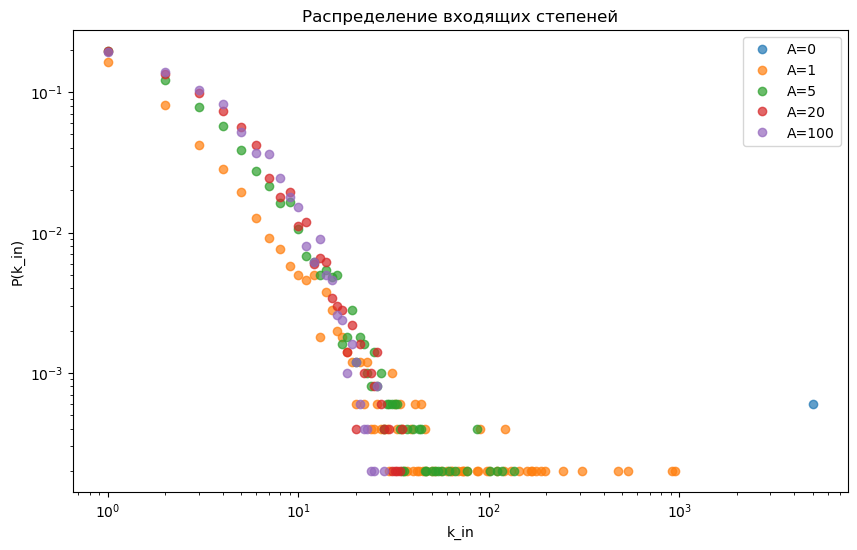

In [ ]:
plt.figure(figsize=(10,6))

for A in [0,1,5,20,100]:
    degrees = results[A][0]
    
    vals, counts = np.unique(degrees, return_counts=True)
    probs = counts / counts.sum()
    
    mask = (vals > 0)
    
    plt.loglog(vals[mask], probs[mask], 'o', label=f"A={A}", alpha=0.7)

plt.xlabel("k_in")
plt.ylabel("P(k_in)")
plt.legend()
plt.title("Распределение входящих степеней")
plt.show()

$A = 0:$
- Почти все точки лежат внизу
- И один экстремальный выброс далеко вправо (супер-хаб)

Это конденсация. Никакого стабильного степенного хвоста нет. Победитель забирает всё

$A = 1:$

- В области малых k почти прямая линия
- Длинный тяжёлый хвост
- Почти линейная зависимость в log–log

Это степенное распределение.

$А = 5:$

- Хвост уже начинает загибаться вниз
- Степенной участок короче
- Появляется усечение

Переход к затянутой экспоненте.

$А = 20:$

- Явный изгиб вниз
- Хвост обрывается
- Степенной участок почти исчез

Затянутая экспонента.

$А = 100: $
- Резкий экспоненциальный спад
- Тяжёлого хвоста нет

Почти случайная сеть.

Вывод: существуют три режима:

- $A = 0$: конденсация
- Малые A: степенное распределение
- Большие A: экспоненциальное распределение

Параметр A ослабляет эффект предпочтительного присоединения.

In [ ]:
def reciprocal_fraction(edges):
    reciprocal = 0
    
    for (u,v) in edges:
        if (v,u) in edges:
            reciprocal += 1
    
    # каждую двунаправленную пару считаем один раз
    return reciprocal / len(edges)

for A in [0,1,5,20,100]:
    edges = results[A][2]
    frac = reciprocal_fraction(edges)
    print(f"A={A}, reciprocal fraction={frac}")

A=0, reciprocal fraction=0.00040008001600320064
A=1, reciprocal fraction=0.00040008001600320064
A=5, reciprocal fraction=0.00040008001600320064
A=20, reciprocal fraction=0.00040008001600320064
A=100, reciprocal fraction=0.00040008001600320064


Доля двунаправленных связей крайне мала (~0.04 %). Практически не зависит от A.
В модели каждая новая вершина создаёт только исходящие связи, а обратные связи могут появиться лишь случайно, если позже какая-то новая вершина выберет старую вершину. Для больших сетей вероятность этого очень мала.

Основная зависимость распределения степеней — от параметра A. Доля двунаправленных связей почти не влияет на распределение в данной модели

In [ ]:
def generate_network_with_removal(N=5000, m=3, A=1, r=0.01):
    edges = set()
    indeg = defaultdict(int)
    nodes = list(range(m+1))
    for i in nodes:
        for j in nodes:
            if i != j:
                edges.add((i,j))
                indeg[j] += 1

    next_node = m+1

    while next_node < N:
        # удаление вершины с вероятностью r
        if random.random() < r and nodes:
            remove = random.choice(nodes)
            nodes.remove(remove)
            edges = set((u,v) for (u,v) in edges if u != remove and v != remove)
            indeg = defaultdict(int)
            for u,v in edges:
                indeg[v] += 1

        nodes.append(next_node)
        total = sum(A + indeg[n] for n in nodes[:-1])
        probs = [(A + indeg[n])/total for n in nodes[:-1]]
        targets = np.random.choice(nodes[:-1], size=m, replace=False, p=probs)
        for t in targets:
            edges.add((next_node, t))
            indeg[t] += 1

        next_node += 1

    return edges, indeg

In [ ]:
edges, indeg = generate_network_with_removal(N=5000, m=3, A=1, r=0.0)
degrees = list(indeg.values())
print("mean:", np.mean(degrees), "var:", np.var(degrees), "min:", np.min(degrees), "max:", np.max(degrees))
edges, indeg = generate_network_with_removal(N=5000, m=3, A=1, r=0.01)
degrees = list(indeg.values())
print("mean:", np.mean(degrees), "var:", np.var(degrees), "min:", np.min(degrees), "max:", np.max(degrees))
edges, indeg = generate_network_with_removal(N=5000, m=3, A=5, r=0.0)
degrees = list(indeg.values())
print("mean:", np.mean(degrees), "var:", np.var(degrees), "min:", np.min(degrees), "max:", np.max(degrees))

mean: 3.000600120024005 var: 495.1676331665613 min: 0 max: 742
mean: 2.974566007266855 var: 416.8269671612667 min: 0 max: 821
mean: 3.000600120024005 var: 35.54450854163631 min: 0 max: 133


Добавление удаления создаёт конкуренцию двух процессов:
- рост
- разрушение структуры

Если:
- если r маленькое, то рост доминирует. Степенной закон сохраняется
- если r больше или A больше, то эффект предпочтительного присоединения ослабевает. Возникает экспоненциальное усечение

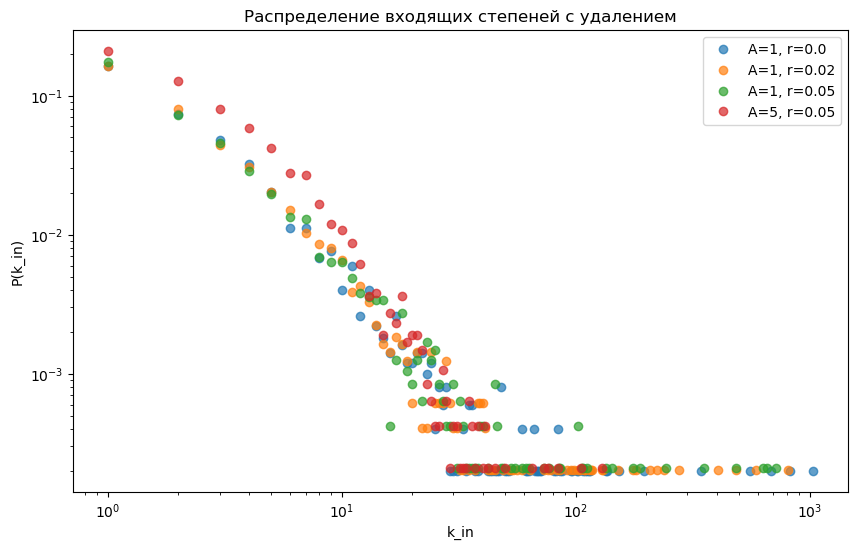

In [ ]:
param_grid = [
    (1, 0.0),
    (1, 0.02),
    (1, 0.05),
    (5, 0.05),
]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for A, r in param_grid:
    edges, indeg = generate_network_with_removal(N=5000, m=3, A=A, r=r)
    degrees = np.array(list(indeg.values()))
    
    vals, counts = np.unique(degrees, return_counts=True)
    probs = counts / counts.sum()
    
    mask = vals > 0
    plt.loglog(vals[mask], probs[mask], 'o', label=f"A={A}, r={r}", alpha=0.7)

plt.legend()
plt.xlabel("k_in")
plt.ylabel("P(k_in)")
plt.title("Распределение входящих степеней с удалением")
plt.show()

Существует два режима распределения входящих степеней:
- степенной закон при малых A и r
- затянутая экспонента при больших А или r

При A=1, r=0.05 начинается переход, на A=5, r=0.05 разделение уже явно заметно

In [ ]:
def generate_with_internal_links(N=5000, m=3, A=1):
    edges = set()
    indeg = defaultdict(int)
    nodes = list(range(m+1))
    
    # начальная сеть
    for i in nodes:
        for j in nodes:
            if i != j:
                edges.add((i,j))
                indeg[j] += 1
    
    next_node = m+1
    
    while next_node < N:
        
        # добавление новой вершины
        nodes.append(next_node)
        total = sum(A + indeg[n] for n in nodes[:-1])
        probs = [(A + indeg[n])/total for n in nodes[:-1]]
        targets = np.random.choice(nodes[:-1], size=m, replace=False, p=probs)
        
        for t in targets:
            edges.add((next_node, t))
            indeg[t] += 1
        
        # внутренние случайные связи
        for _ in range(m):
            u, v = random.sample(nodes, 2)
            if (u,v) not in edges:
                edges.add((u,v))
                indeg[v] += 1
        
        next_node += 1
    
    return edges, indeg

In [ ]:

for m_ in [1,3,10]:
    edges, indeg = generate_with_internal_links(N=5000, m=m_, A=1)
    degrees = list(indeg.values())
    print("m:", m_, "mean:", np.mean(degrees), "var:", np.var(degrees), "min:", np.min(degrees), "max:", np.max(degrees))

    # edges, indeg = generate_network_with_removal(N=5000, m=3, A=1, r=0.0)
    # degrees = list(indeg.values())
    # print("mean:", np.mean(degrees), "var:", np.var(degrees), "min:", np.min(degrees), "max:", np.max(degrees))

m: 1 mean: 1.9985997199439889 var: 15.202038447297378 min: 0 max: 69
m: 3 mean: 5.9783956791358275 var: 151.14656265920115 min: 0 max: 233
m: 10 mean: 19.780356071214243 var: 1540.2918245581502 min: 0 max: 560


- Средняя входящая степень ≈ 2m, так как на каждом шаге новая вершина создаёт m рёбер, дополнительно создаётся m внутренних рёбер. Так как каждое ребро даёт одну входящую степень, то средняя входящую степень будем считать за 2m
- Дисперсия с ростом m резко увеличивается
- максимальная степень растёт
- тип распределения с ростом m:
    - хвост становится тяжелее
    - разброс степеней растёт
    - усиливается хабовая структура


In [ ]:
def reciprocal_fraction(edges):
    reciprocal = 0
    
    for (u,v) in edges:
        if (v,u) in edges:
            reciprocal += 1
    
    return reciprocal / len(edges)

for m in [1,3,10]:
    edges, indeg = generate_with_internal_links(N=5000, m=m, A=1)
    frac = reciprocal_fraction(edges)
    print(f"m={m}, reciprocal fraction={frac}")

m=1, reciprocal fraction=0.0022030843180452634
m=3, reciprocal fraction=0.007097184560275853
m=10, reciprocal fraction=0.017398517079881447


Доля двунаправленныхх связей растет с увеличением m

В пункте 1 новые вершины создавали только исходящие связи, обратные связи возникали крайне редко. 

В пункте 3 мы добавляем случайные внутренние связи, вероятность создать ребро в противоположном направлении увеличивается. Сеть становится плотнее и вероятность образования взаимной пары растёт.

Таким образом, доля двунаправленных связей зависит от
- m(числа внутренних связей)
- Размера сети N
- плотности графа